In [28]:
import sys
import os
import re
import random
import keras
import warnings 

warnings.filterwarnings("ignore")

sys.path.append('../../../LIB/')
from utils import *
from customClasses.utils import *
from wordcloud import WordCloud, STOPWORDS

np.random.seed(42)
pd.set_option('display.max_columns', 100, 'display.width', 1024)
pd.options.mode.chained_assignment = None

plt.rcParams['axes.facecolor'] = '#12162f'
plt.grid(False)
plt.close()

DATA_PATH = 'data/'
SPLIT_DATE = '2019-01-01'

In [7]:
# Read CSV casitng dates
answers = pd.read_csv(os.path.join(DATA_PATH, 'answers.csv'))
answer_scores = pd.read_csv(os.path.join(DATA_PATH, 'answer_scores.csv'))
comments = pd.read_csv(os.path.join(DATA_PATH, 'comments.csv'))
emails = pd.read_csv(os.path.join(DATA_PATH, 'emails.csv'))
groups = pd.read_csv(os.path.join(DATA_PATH, 'groups.csv'))
group_memberships = pd.read_csv(os.path.join(DATA_PATH, 'group_memberships.csv'))
matches = pd.read_csv(os.path.join(DATA_PATH, 'matches.csv'))
professionals = pd.read_csv(os.path.join(DATA_PATH, 'professionals.csv'))
questions = pd.read_csv(os.path.join(DATA_PATH, 'questions.csv'))
question_scores = pd.read_csv(os.path.join(DATA_PATH, 'question_scores.csv')) 
school_memberships = pd.read_csv(os.path.join(DATA_PATH, 'school_memberships.csv'))
students = pd.read_csv(os.path.join(DATA_PATH, 'students.csv'))
tags = pd.read_csv(os.path.join(DATA_PATH, 'tags.csv'))
tag_questions = pd.read_csv(os.path.join(DATA_PATH, 'tag_questions.csv'))
tag_users = pd.read_csv(os.path.join(DATA_PATH, 'tag_users.csv'))

In [8]:
# Datetimes features preprocessing
answers['answers_date_added'] = pd.to_datetime(answers['answers_date_added'], infer_datetime_format=True)
comments['comments_date_added'] = pd.to_datetime(comments['comments_date_added'], infer_datetime_format=True)
emails['emails_date_sent'] = pd.to_datetime(emails['emails_date_sent'], infer_datetime_format=True)
professionals['professionals_date_joined'] = pd.to_datetime(professionals['professionals_date_joined'], infer_datetime_format=True)
questions['questions_date_added'] = pd.to_datetime(questions['questions_date_added'], infer_datetime_format=True)
students['students_date_joined'] = pd.to_datetime(students['students_date_joined'], infer_datetime_format=True)

Activity features used in EDA


User activities divided into 3 main categories:

- Answer
- Question
- Comment

Time of these activities helps us to derive essential features such us date_last_activity which is used later on in activity based recommendation decisions

In [9]:
# Last Answer
temp = answers.groupby('answers_author_id')['answers_date_added'].max()
professionals['date_last_answer'] = pd.merge(professionals, pd.DataFrame(temp.rename('last_answer')), left_on='professionals_id', right_index=True, how='left')['last_answer']
# First Answer
temp = answers.groupby('answers_author_id')['answers_date_added'].min()
professionals['date_first_answer'] = pd.merge(professionals, pd.DataFrame(temp.rename('first_answer')), left_on='professionals_id', right_index=True, how='left')['first_answer']
# Last Comment
temp = comments.groupby('comments_author_id')['comments_date_added'].max()
professionals['date_last_comment'] = pd.merge(professionals, pd.DataFrame(temp.rename('last_comment')), left_on='professionals_id', right_index=True, how='left')['last_comment']
# First Comment
temp = comments.groupby('comments_author_id')['comments_date_added'].min()
professionals['date_first_comment'] = pd.merge(professionals, pd.DataFrame(temp.rename('first_comment')), left_on='professionals_id', right_index=True, how='left')['first_comment']
# Last Activity
professionals['date_last_activity'] = professionals[['date_last_answer', 'date_last_comment']].max(axis=1)
# First Activity
professionals['date_first_activity'] = professionals[['date_first_answer', 'date_first_comment']].min(axis=1)

# Last activity (Question)
temp = questions.groupby('questions_author_id')['questions_date_added'].max()
students['date_last_question'] = pd.merge(students, pd.DataFrame(temp.rename('last_question')), left_on='students_id', right_index=True, how='left')['last_question']
# First activity (Question)
temp = questions.groupby('questions_author_id')['questions_date_added'].min()
students['date_first_question'] = pd.merge(students, pd.DataFrame(temp.rename('first_question')), left_on='students_id', right_index=True, how='left')['first_question']
# Last activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].max()
students['date_last_comment'] = pd.merge(students, pd.DataFrame(temp.rename('last_comment')), left_on='students_id', right_index=True, how='left')['last_comment']
# First activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].min()
students['date_first_comment'] = pd.merge(students, pd.DataFrame(temp.rename('first_comment')), left_on='students_id', right_index=True, how='left')['first_comment']
# Last activity (Total)
students['date_last_activity'] = students[['date_last_question', 'date_last_comment']].max(axis=1)
# First activity (Total)
students['date_first_activity'] = students[['date_first_question', 'date_first_comment']].min(axis=1)

In [10]:
pro_emails = pd.merge(professionals, emails, how='inner', left_on='professionals_id', right_on='emails_recipient_id')
pro_emails = pro_emails[pro_emails['emails_frequency_level'] == 'email_notification_immediate']
pro_emails = pro_emails[['professionals_id', 'emails_id', 'emails_date_sent']]

pro_email_ques = pro_emails.merge(matches, left_on='emails_id', right_on='matches_email_id')
pro_email_ques = pro_email_ques.drop(columns=['emails_id', 'matches_email_id']) \
                 .set_index('professionals_id').rename(columns={'matches_question_id': 'questions_id'})

Users Activities

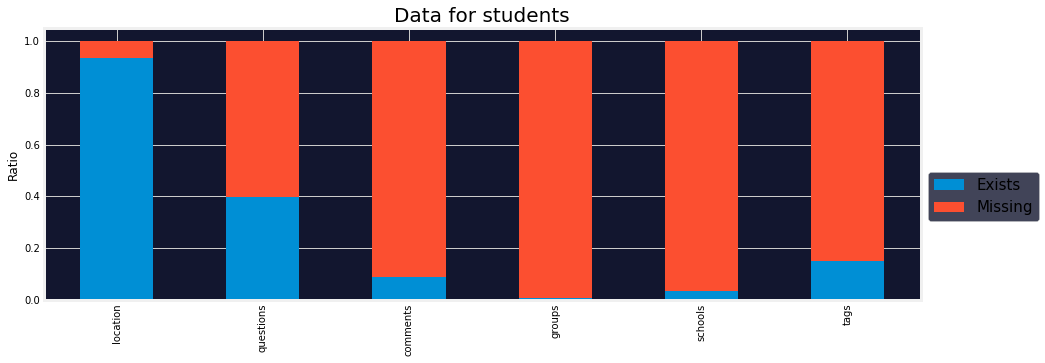

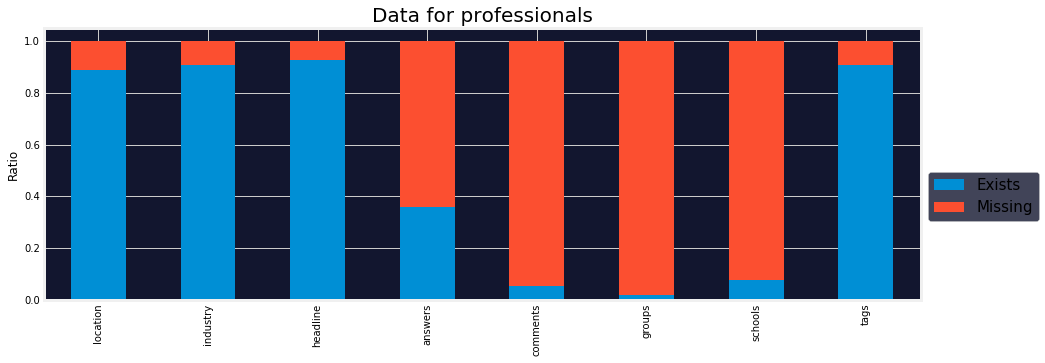

In [13]:
exists = 'Exists'
miss = 'Missing'

fields = {
    'students': {
        'df': students,
        'features': ['location'],
        'count': {
            'questions': questions,
            'comments': comments
        },
        'memberships': {
            'groups': group_memberships,
            'schools': school_memberships
        },
        'plts': {}
    },
    'professionals': {
        'df': professionals,
        'features': ['location', 'industry', 'headline'],
        'count': {
            'answers': answers,
            'comments': comments
        },
        'memberships': {
            'groups': group_memberships,
            'schools': school_memberships
        },
        'plts': {} 
    }
}

for user in fields.keys():
    user_spec = fields[user]
    
    df = user_spec['df']
    
    tmp = df[['{}_{}'.format(user, feature) for feature in user_spec['features']]]
    tmp = tmp.fillna(miss)
    tmp[tmp != miss] = exists 

    for feature in user_spec['features']:
        user_spec['plts'][feature] = tmp.groupby('{}_{}'.format(user, feature)).size()/len(tmp)
    
    # Counts
    for key, cdf in user_spec['count'].items():
        tf = cdf.groupby('{}_author_id'.format(key)).size()
        tf['counts'] = pd.merge(df, pd.DataFrame(tf.rename('count')), left_on='{}_id'.format(user), right_index=True, how='left')['count'].fillna(0).astype(int)
        
        tf = tf['counts']
        tf[tf > 0] = exists
        tf[tf != exists] = miss
        
        user_spec['plts'][key] = tf.groupby(tf.values).size()/len(tf)

    # Counts
    for key, mdf in user_spec['memberships'].items():
        unique_userid_with_membership = mdf['{}_memberships_user_id'.format(key[:-1])].unique()
        tf = pd.DataFrame()
        tf['val'] = df['{}_id'.format(user)]
        
        tf[tf['val'].isin(unique_userid_with_membership)] = exists
        tf[tf['val'] != exists] = miss

        user_spec['plts'][key] = tf.groupby('val').size()/len(tf)
        
    # Tags
    unique_user_ids_with_tags = tag_users['tag_users_user_id'].unique()
    tf = pd.DataFrame()
    tf['val'] = df['{}_id'.format(user)]
    
    tf[tf['val'].isin(unique_user_ids_with_tags)] = exists
    tf[tf['val'] != exists] = miss
    
    user_spec['plts']['tags'] = tf.groupby('val').size()/len(tf)
    plt_data = pd.DataFrame(user_spec['plts'])
    
    plt_data.T.plot(kind='bar', stacked=True, figsize=(14, 5))
    plt.ylabel('Ratio')
    plt.title('Data for {}'.format(user), fontsize=20)
    leg = plt.legend(bbox_to_anchor=(1, 0.5), fontsize=15)
    plt.show()

User locations

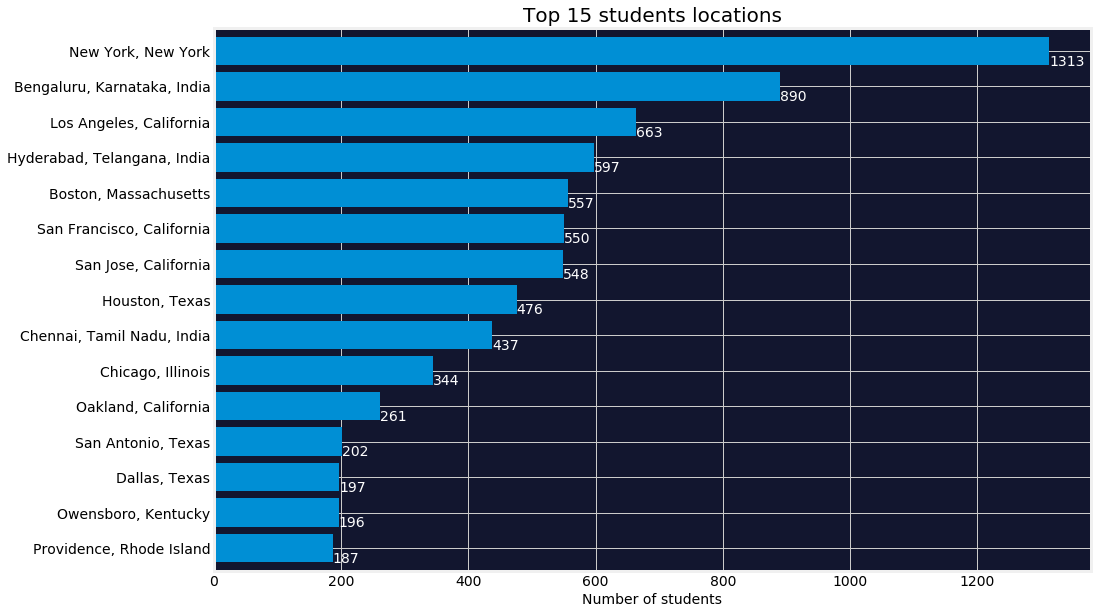

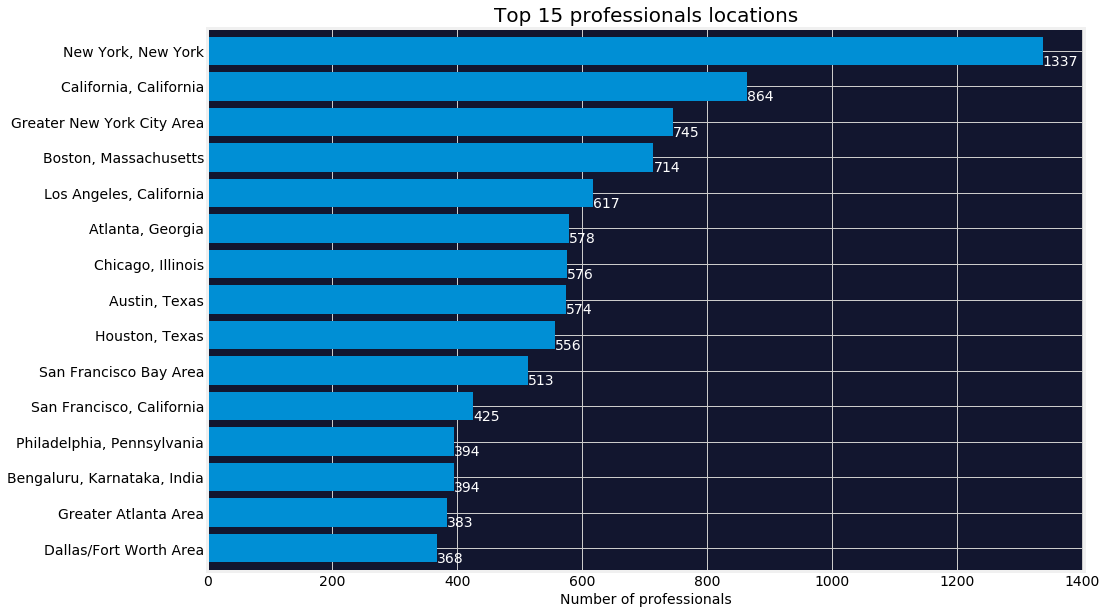

In [14]:
n_locations = 15

users = [
    ('students', students),
    ('professionals', professionals)
]

for user, df in users:
    locations = df['{}_location'.format(user)].value_counts().sort_values(ascending=True).tail(n_locations)
    
    ax = locations.plot(kind='barh',figsize=(14, 10),width=0.8, fontsize=14) 
    ax.set_title('Top %s {} locations'.format(user) % n_locations, fontsize=20)
    ax.set_xlabel('Number of {}'.format(user), fontsize=14)
    for p in ax.patches:
        ax.annotate(str(p.get_width()), (p.get_width(), p.get_y()), color='w', fontsize=14)
    plt.show()
    

Number of Answers & Questions added per year

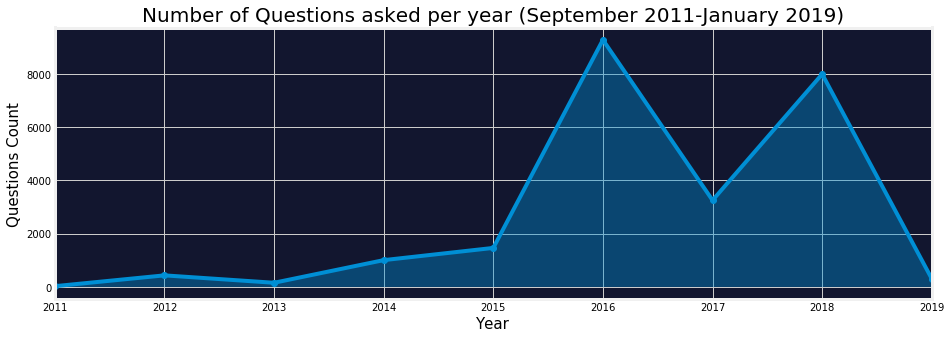

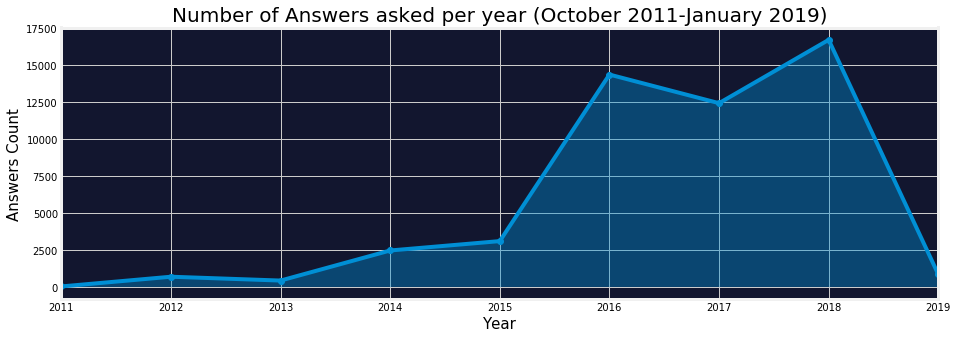

In [16]:
entities = [
    ('questions', questions),
    ('answers', answers)
]


for entity, df in entities:
    min_date = df['{}_date_added'.format(entity)].min().strftime("%B %Y")
    max_date = df['{}_date_added'.format(entity)].max().strftime("%B %Y")

    df['year'] = df['{}_date_added'.format(entity)].dt.year
    plt_data = df.groupby('year').size()
    plt_data.plot(figsize=(14, 5),  marker='o')

    x = plt_data.reset_index()['year']
    y = plt_data.reset_index()[0]
    plt.fill_between(x, y, alpha = 0.4)

    plt.xlabel('Year', fontsize=15)
    plt.ylabel('{} Count'.format(entity.capitalize()), fontsize=15)
    plt.title('Number of {} asked per year ({}-{})'.format(entity.capitalize(), min_date, max_date), fontsize=20)
    plt.show()

Top n Professionals with most Answers & Students with most Questions

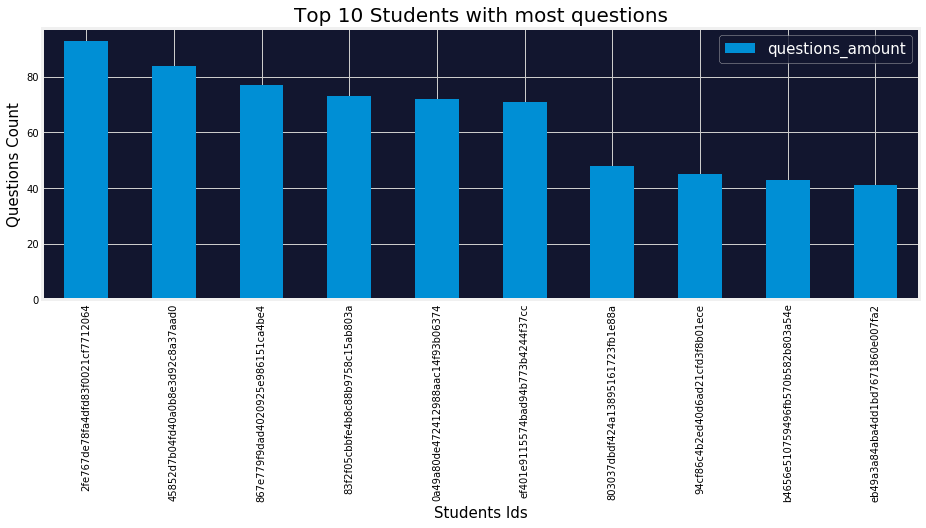

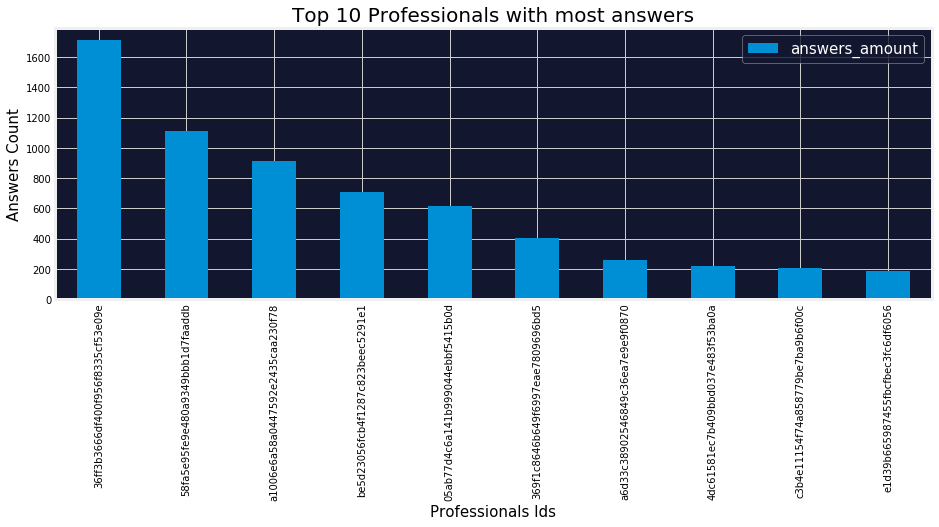

In [19]:
n=10
ll = [
    ('students', 'questions', students, questions),
    ('professionals', 'answers', professionals, answers)
]

for user, entity, user_df, entity_df in ll:
    top_n = pd.DataFrame(pd.merge(user_df, entity_df, left_on='{}_id'.format(user), right_on='{}_author_id'.format(entity), how='inner').groupby('{}_id'.format(user)).size().reset_index())
    plt_data = top_n.rename(index=str, columns={0: '{}_amount'.format(entity)}).sort_values(by=['{}_amount'.format(entity)], ascending=False)[:n]

    plt_data.plot(kind='bar', figsize=(14, 5))
    plt.xticks(np.arange(len(plt_data)), tuple(plt_data['{}_id'.format(user)]), rotation=90)
    plt.xlabel('{} Ids'.format(user.capitalize()), fontsize=15)
    plt.ylabel('{} Count'.format(entity.capitalize()), fontsize=15)
    plt.title('Top {} {} with most {}'.format(n, user.capitalize(), entity), fontsize=20)
    leg = plt.legend(loc='best', fontsize=15)
    for text in leg.get_texts():
        plt.setp(text, color = 'w')
    plt.show()

worcloud tags

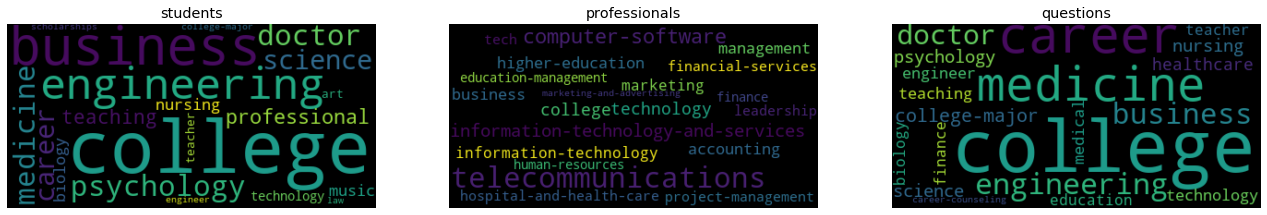

In [27]:
entities = [
    ('students', students),
    ('professionals', professionals),
    ('questions', questions)
]

dfs = []

for entity, df in entities:
    if entity == 'questions':
        df = tag_questions
        df = pd.merge(df, tags, left_on='tag_questions_tag_id', right_on='tags_tag_id')
    else:
        df = tag_users[tag_users['tag_users_user_id'].isin(df['{}_id'.format(entity)])]
        df = pd.merge(df, tags, left_on='tag_users_tag_id', right_on='tags_tag_id')

    df['entity_type'] = entity

    dfs.append(df)


plt_data = pd.concat(dfs)


plt_data = plt_data[['tags_tag_name', 'entity_type']].pivot_table(index='tags_tag_name', columns='entity_type', aggfunc=len, fill_value=0)

for entity, df in entities:
    plt_data[entity] = plt_data[entity] / len(df)

plt_data['sum'] = (plt_data['professionals'] + plt_data['students'] + plt_data['questions'])
plt_data = plt_data.sort_values(by='sum', ascending=False).drop(['sum'], axis=1).head(100)


# Wordcloud
plt.figure(figsize=(20, 20))
wordloud_values = ['students', 'professionals', 'questions']
axisNum = 1
for wordcloud_value in wordloud_values:
    wordcloud = WordCloud(margin=0, max_words=20, random_state=42).generate_from_frequencies(plt_data[wordcloud_value])
    ax = plt.subplot(1, 3, axisNum)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(wordcloud_value)
    plt.axis("off")
    axisNum += 1
plt.show()    